In [ ]:
# Create pytorch dataset from hf dataset

> first download hugingface dataset and then convert it pytorch dataset with augmentation, to work further

In [ ]:
#| default_exp pytorch_ds_creation

In [ ]:
#| export
from datasets import load_dataset, Dataset as HFDataset
from torch.utils.data import Dataset
from typing import List, Dict, Union, Optional, Tuple
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib as mpl 
import albumentations as A

In [ ]:
#| export
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

In [ ]:
#| hide
mpl.rcParams['image.cmap'] = 'gray'
DPI = mpl.rcParams['figure.dpi']

In [ ]:
IMAGE_HEGHT = 256
IMAGE_WIDTH = 256
IN_CHANNELS = 1
OUT_CHANNELS = 1

In [ ]:
#| hide
dataset = load_dataset("hasangoni/Electron_microscopy_dataset")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /home/hasan/.cache/huggingface/datasets/hasangoni___parquet/hasangoni--Electron_microscopy_dataset-2e0b773ba35eb66f/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#| hide
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1642
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1725
    })
})

In [ ]:
#| export
def show_hf_dataset(
        dataset:HFDataset,
        idx:Union[int, None]=None,
        split:str='train'
        ):
    "Show hugging face random index"

    if idx is None:
        idx = np.random.randint(0, len(dataset[split]))

    print(f' dataset index will be visualized: {idx}')
    im_ = dataset[split]['image'][idx]
    msk_ = dataset[split]['label'][idx]
    fig, ax = plt.subplots(
        1, 2, figsize=(10, 5)
    )
    ax[0].imshow(im_)
    ax[0].set_title('image')
    ax[0].axis('off')
    ax[1].imshow(msk_)
    ax[1].set_title('mask')
    ax[1].axis('off')
    

Now testing 

 dataset index will be visualized: 106


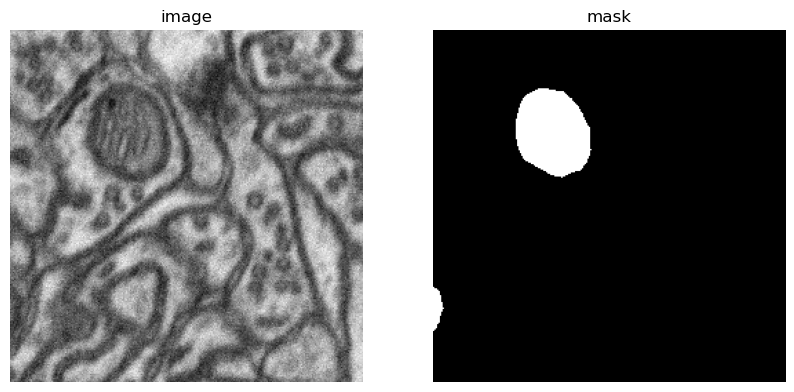

In [ ]:
show_hf_dataset(dataset)

In [ ]:

#msk_no = len(dataset['train']['label'])
#mask_max =[np.max(np.array(dataset['train']['label'][i])) for i in range(msk_no)]

In [ ]:
def visualize_map(image, segmentation_map):
    color_seg = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 1), dtype=np.uint8) # height, width, 3
    for label, color in id2color.items():
        color_seg[segmentation_map == label, :] = color

In [ ]:
#| export
class SegmentationDataset(Dataset):
  def __init__(
              self, 
              dataset, 
              transform # Transformations
              ):
    self.dataset = dataset
    self.transform = transform

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    original_image = np.expand_dims(np.array(item["image"]),axis=-1)
    original_segmentation_map = np.expand_dims(np.array(item["label"]),-1)

    transformed = self.transform(image=original_image, mask=original_segmentation_map)
    image, target = torch.tensor(transformed['image']), torch.LongTensor(transformed['mask'])
    #print(image.shape)

    #########################################################################################
    # convert to C, H, W
    image = image.permute(2,0,1)
    target = target.permute(2,0,1)
    #########################################################################################

    return image, target, original_image, original_segmentation_map

In [ ]:
MEAN =0
STD = 1
train_transform = A.Compose([
    A.Resize(width=IMAGE_WIDTH, height=IMAGE_HEGHT),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=MEAN, std=STD),
    
])

val_transform = A.Compose([
    A.Resize(width=IMAGE_WIDTH, height=IMAGE_HEGHT),
    A.Normalize(mean=MEAN, std=STD),

])

In [ ]:
#ds_test = load_dataset("EduardoPacheco/FoodSeg103")

In [ ]:
#msk=ds_test['train']['label'][0]

In [ ]:
#np.array(msk).shape

In [ ]:
#msk

In [ ]:
id2label = {0: 'background', 1: 'Pin'}

In [ ]:
pixel_values, target, original_image, original_segmentation_map = train_dataset[3]
print(pixel_values.shape)
print(target.shape)
     

torch.Size([256, 256, 1])
torch.Size([1, 256, 256])
torch.Size([256, 256])


In [ ]:
def collate_fn(inputs):
    batch = dict()
    batch["pixel_values"] = torch.stack([i[0] for i in inputs], dim=0)
    batch["labels"] = torch.stack([i[1] for i in inputs], dim=0)
    batch["original_images"] = [i[2] for i in inputs]
    batch["original_segmentation_maps"] = [i[3] for i in inputs]

    return batch


In [ ]:

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn, num_workers=2)

In [ ]:

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v,torch.Tensor):
    print(k,v.shape)
     

torch.Size([256, 256, 1])
torch.Size([256, 256, 1])
torch.Size([256, 256, 1])
torch.Size([256, 256, 1])
torch.Size([256, 256, 1])
torch.Size([256, 256, 1])
torch.Size([256, 256, 1])
torch.Size([256, 256, 1])
pixel_values torch.Size([2, 1, 256, 256])
labels torch.Size([2, 256, 256])


In [ ]:
batch["pixel_values"].dtype, batch["labels"].dtype

(torch.float32, torch.int64)

(1, 256, 256)
(256, 256, 1)


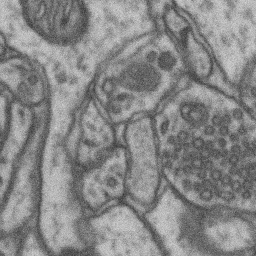

In [ ]:


unnormalized_image = batch["pixel_values"][0].numpy() * np.array(STD)+ np.array(MEAN)
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
print(unnormalized_image.shape)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
print(unnormalized_image.shape)
unnormalized_image = Image.fromarray(unnormalized_image[:,:,0])
unnormalized_image

In [ ]:
#| export
class UNetSmall(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetSmall, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Middle
        self.middle = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(96, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, out_channels, kernel_size=1)
        )
        
    def forward(self, x):
        # Encoder
        x1 = self.encoder(x)
        
        # Middle
        x2 = self.middle(x1)
        
        # Decoder
        x3 = torch.cat([x1, x2], dim=1)
        x4 = self.decoder(x3)
        
        return x4


In [ ]:
#| export
class TverskyFocalLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=2.0, epsilon=1e-5):
        super(TverskyFocalLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.epsilon = epsilon

    def forward(self, y_true, y_pred):
        y_true = y_true.view(-1)
        y_pred = y_pred.view(-1)

        true_positive = (y_true * y_pred).sum()
        false_positive = ((1 - y_true) * y_pred).sum()
        false_negative = (y_true * (1 - y_pred)).sum()

        tversky = (true_positive + self.epsilon) / (true_positive + self.alpha * false_positive + self.beta * false_negative + self.epsilon)

        focal_tversky = (1 - tversky)**self.gamma

        return focal_tversky.mean()


In [ ]:
# creating dataset
train_dataset = SegmentationDataset(dataset["train"], transform=train_transform)
val_dataset = SegmentationDataset(dataset["test"], transform=val_transform)

# now dataloader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn, num_workers=2)

In [ ]:
def save_model(model, save_path):
    Path(save_path).parent.mkdir(exist_ok=True, parents=True)
    torch.save(model.state_dict(), save_path)

In [ ]:
#| export
def train(
        train_dataloader:DataLoader,
        val_dataloader:DataLoader,
        optimizer:torch.optim.Optimizer,
        model:torch.nn.Module,
        criterion:torch.nn.Module,
        device:torch.device,
        epochs:int,
        save_path:str
):
    num_epochs = epochs
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.00001)

    for epoch in range(num_epochs):
        print(f'epoch: {epoch+1}/{num_epochs}')

        model.train()

        for idx, batch in enumerate(tqdm(train_dataloader)):
            images = batch['pixel_values'].to(device)
            masks = batch['labels'].to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()
        scheduler.step()  # Update learning rate
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.8f}')

         # Validation loop
        model.eval()
        with torch.no_grad():
            total_val_loss = 0
            for idx, val_batch in enumerate(tqdm(val_dataloader)):
                val_images = val_batch['pixel_values'].to(device)
                val_masks = val_batch['labels'].to(device)
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {avg_val_loss:.4f}')

    save_model(model, save_path)



In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f'Using device: {device}')


Using device: cuda


In [ ]:
# creating dataset
train_dataset = SegmentationDataset(dataset["train"], transform=train_transform)
val_dataset = SegmentationDataset(dataset["test"], transform=val_transform)

# now dataloader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn, num_workers=2)

In [ ]:
model = UNetSmall(IN_CHANNELS, OUT_CHANNELS).to(device)
criterion = TverskyFocalLoss(alpha=0.7, beta=0.3, gamma=2.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)

In [ ]:
for name, param in model.named_parameters():
    print(name)

encoder.0.weight
encoder.0.bias
encoder.2.weight
encoder.2.bias
middle.0.weight
middle.0.bias
decoder.0.weight
decoder.0.bias
decoder.2.weight
decoder.2.bias
decoder.4.weight
decoder.4.bias


In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
batch['labels'].shape

torch.Size([2, 1, 256, 256])

In [ ]:

logits=model(batch['pixel_values'].to(device))
logits.shape
criterion(logits, batch['labels'].to(device))


tensor(0.9611, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    model=model,
    device=device,
    epochs=1,
    save_path='model.pth'


)

epoch: 1/1


  0%|          | 0/821 [00:00<?, ?it/s]

Epoch [1/1], Loss: 0.0003, Learning Rate: 0.00001000


  0%|          | 0/863 [00:00<?, ?it/s]

Epoch [1/1], Loss: 0.0003, Val Loss: 0.0003


In [ ]:
def load_model(model, checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()  # Set the model to evaluation mode
    return model

In [ ]:
checkpoint_path = 'model.pth'

In [ ]:
loaded_model = load_model(UNetSmall(IN_CHANNELS, OUT_CHANNELS), checkpoint_path)
loaded_model = loaded_model.to(device)

In [ ]:
inf_img = val_transform(image=np.array(dataset['test']['image'][0]))
inf_img['image'].shape

(256, 256)

In [ ]:
new_img=(inf_img['image'])

In [ ]:
inp_img_infr = np.expand_dims(np.expand_dims(new_img,axis=-1),0).shape

In [ ]:
loaded_model(torch.tensor(np.expand_dims(np.expand_dims(new_img,axis=-1),0)).to(device))

RuntimeError: Given groups=1, weight of size [16, 1, 3, 3], expected input[1, 256, 256, 1] to have 1 channels, but got 256 channels instead

In [ ]:
inp_img_infr=inp_img_infr.to(device)

AttributeError: 'tuple' object has no attribute 'to'